<a href="https://colab.research.google.com/github/NeetJain27/SmartAgricultureSystem/blob/main/EXTC_rain_temp_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder,StandardScaler

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Conv1D, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
df = pd.read_csv('/content/final_df.csv')
df.head()

,District,Crop,Year,Season,Area,Temperature,Rainfall,Yield
0,1,2,1997,2,40800.0,23.998425,112.450,0.455882
1,1,4,1997,2,900.0,23.998425,112.450,1.222222
2,1,4,1997,3,598400.0,21.448471,9.375,0.362634
3,1,5,1997,2,4400.0,23.998425,112.450,1.068182
4,1,5,1997,3,6200.0,21.448471,9.375,1.467742


In [ ]:
rows_to_drop = df[(df['Yield'] < 0) | (df['Yield'] > 100)].index

df = df.drop(index=rows_to_drop)
df = df.reset_index(drop=True)

In [ ]:
df.shape

(13904, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13904 entries, 0 to 13903
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   District     13904 non-null  int64  
 1   Crop         13904 non-null  int64  
 2   Year         13904 non-null  int64  
 3   Season       13904 non-null  int64  
 4   Area         13904 non-null  float64
 5   Temperature  13904 non-null  float64
 6   Rainfall     13904 non-null  float64
 7   Yield        13904 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 869.1 KB


## We use multiple different models to compare and evaluate the best performing one (by comparing the RMSE scores)

In [ ]:
X = df.drop(columns=['Rainfall', 'Temperature','Yield','Area','Crop'])
y = df['Rainfall']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11123, 3), (2781, 3), (11123,), (2781,))

In [ ]:
X_train

,District,Year,Season
13434,7,2023,2
5556,26,2007,2
2252,24,2001,2
12522,26,2021,2
2578,11,2002,2
...,...,...,...
5191,4,2007,3
13418,7,2023,2
5390,16,2007,4
860,8,1999,2


# RandomForest Regressor

In [ ]:
rf_r = RandomForestRegressor(n_estimators=100, random_state=42)
rf_r.fit(X_train, y_train)

y_pred_rf = rf_r.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest R² Score: {r2_rf}")

Random Forest RMSE: 25.30103244330996
Random Forest R² Score: 0.9548741341988871


# GradientBoost Regressor

In [ ]:
gb_r = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_r.fit(X_train, y_train)

y_pred_gb = gb_r.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting RMSE: {rmse_gb}")
print(f"Gradient Boosting R² Score: {r2_gb}")

Gradient Boosting RMSE: 44.31718458065892
Gradient Boosting R² Score: 0.8615498644657082


# XGBoost Regressor

In [ ]:
xgb_r = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_r.fit(X_train, y_train)

y_pred_xgb = xgb_r.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost R² Score: {r2_xgb}")

XGBoost RMSE: 31.245214020353302
XGBoost R² Score: 0.9311797781814973


# LSTM

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model_r = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])),
    LSTM(50, activation='relu', return_sequences=False),
    Dense(25),
    Dense(1)
])

lstm_model_r.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

lstm_model_r.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

y_pred_lstm = lstm_model_r.predict(X_test_reshaped).flatten()

rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"LSTM RMSE: {rmse_lstm}")
print(f"LSTM R² Score: {r2_lstm}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 27506.2305
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 11470.9971
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5106.9341
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4430.0161
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4286.7314
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4528.5483
Epoch 7/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4421.0298
Epoch 8/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4513.1870
Epoch 9/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4320.6680
Epoch 10/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4300.5967
Epoch 11/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4390.2427
Epoch 12/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4234.5664
Epoch 13/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4400.4780
Epoch 14/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4378.1128
Epoch 15/50
3

# SVR

In [ ]:
svm_regressor_r = SVR(kernel='rbf')
svm_regressor_r.fit(X_train, y_train)

y_pred_svr = svm_regressor_r.predict(X_test)

rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVM Regressor RMSE: {rmse_svr:.4f}")
print(f"SVM Regressor R² Score: {r2_svr:.4f}")

SVM Regressor RMSE: 119.8277
SVM Regressor R² Score: -0.0122


### Displaying the results for the various models

In [ ]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LSTM', 'SVR'],
    'RMSE': [rmse_rf, rmse_gb, rmse_xgb, rmse_lstm, rmse_svr],
    'R² Score': [r2_rf, r2_gb, r2_xgb, r2_lstm, r2_svr]
})

print(results)

best_model = results.loc[results['RMSE'].idxmin()]
print(f"Best Model based on RMSE: {best_model['Model']} with RMSE {best_model['RMSE']:.4f}")

best_model_r2 = results.loc[results['R² Score'].idxmax()]
print(f"Best Model based on R² Score: {best_model_r2['Model']} with R² Score {best_model_r2['R² Score']:.4f}")

               Model        RMSE  R² Score
0      Random Forest   25.301032  0.954874
1  Gradient Boosting   44.317185  0.861550
2            XGBoost   31.245214  0.931180
3               LSTM   64.842066  0.703611
4                SVR  119.827722 -0.012194
Best Model based on RMSE: Random Forest with RMSE 25.3010
Best Model based on R² Score: Random Forest with R² Score 0.9549


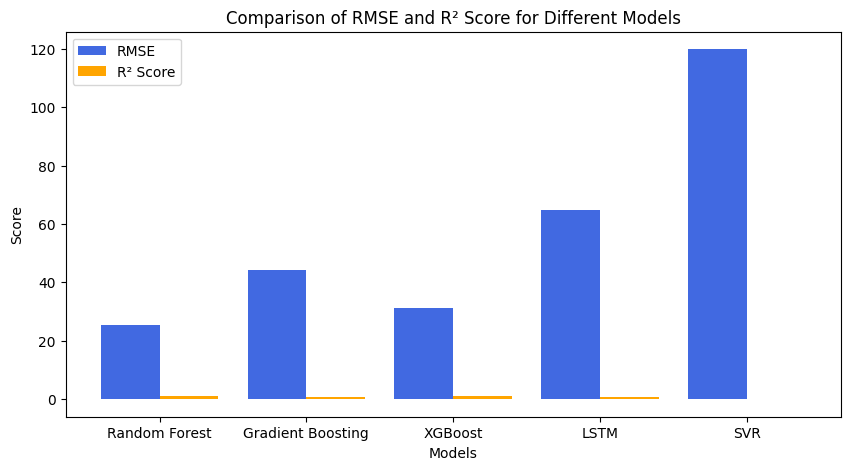

In [ ]:
plt.figure(figsize=(10, 5))

bar_width = 0.4
models = results['Model']
x = np.arange(len(models))

plt.bar(x - bar_width/2, results['RMSE'], width=bar_width, label='RMSE', color='royalblue')
plt.bar(x + bar_width/2, results['R² Score'], width=bar_width, label='R² Score', color='orange')

plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Comparison of RMSE and R² Score for Different Models")
plt.xticks(ticks=x, labels=models)
plt.legend()
plt.show()

### Predicing rainfall

In [ ]:
district = int(input("Enter District (as integer): "))
year = int(input("Enter Year: "))
season = int(input("Enter Season (as integer): "))

user_input = np.array([[district, year, season]])

predicted_rainfall = rf_r.predict(user_input)[0]

print(f"Predicted Rainfall: {predicted_rainfall:.2f} mm")

Enter District (as integer): 7
Enter Year: 2030
Enter Season (as integer): 2
Predicted Rainfall: 182.89 mm


# For Temperature

## We use multiple different models to compare and evaluate the best performing one (by comparing the RMSE scores)

In [ ]:
X = df.drop(columns=['Temperature','Yield','Area','Crop'])
y = df['Temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11123, 4), (2781, 4), (11123,), (2781,))

## Random Forest

In [ ]:
rf_t = RandomForestRegressor(n_estimators=100, random_state=42)
rf_t.fit(X_train, y_train)

y_pred_rf = rf_t.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest R² Score: {r2_rf}")

Random Forest RMSE: 0.30386371816125185
Random Forest R² Score: 0.9884599367227371


## Gradient Boosting Regressor

In [ ]:
gb_t = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_t.fit(X_train, y_train)

y_pred_gb = gb_t.predict(X_test)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting RMSE: {rmse_gb}")
print(f"Gradient Boosting R² Score: {r2_gb}")

Gradient Boosting RMSE: 0.7846039790389119
Gradient Boosting R² Score: 0.9230601195129412


## XGBoost

In [ ]:
xgb_t = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_t.fit(X_train, y_train)

y_pred_xgb = xgb_t.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost R² Score: {r2_xgb}")

XGBoost RMSE: 0.4028382414124856
XGBoost R² Score: 0.9797179486656383


## LSTM

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model_t = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])),
    LSTM(50, activation='relu', return_sequences=False),
    Dense(25),
    Dense(1)
])

lstm_model_t.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

lstm_model_t.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

y_pred_lstm = lstm_model_t.predict(X_test_reshaped).flatten()

rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"LSTM RMSE: {rmse_lstm}")
print(f"LSTM R² Score: {r2_lstm}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


348/348 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 398.9494
Epoch 2/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.0791
Epoch 3/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5026
Epoch 4/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0579
Epoch 5/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.9431
Epoch 6/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.0707
Epoch 7/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.8627
Epoch 8/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.8111
Epoch 9/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6822
Epoch 10/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6501
Epoch 11/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3435
Epoch 12/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.2989
Epoch 13/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0209
Epoch 14/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9004
Epoch 15/50
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.409

## SVR

In [ ]:
svm_regressor_t = SVR(kernel='rbf')
svm_regressor_t.fit(X_train, y_train)

y_pred_svr = svm_regressor_t.predict(X_test)

rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVM Regressor RMSE: {rmse_svr:.4f}")
print(f"SVM Regressor R² Score: {r2_svr:.4f}")

SVM Regressor RMSE: 3.0258
SVM Regressor R² Score: -0.1443


### Displaying the results for the various models

In [ ]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LSTM', 'SVR'],
    'RMSE': [rmse_rf, rmse_gb, rmse_xgb, rmse_lstm, rmse_svr],
    'R² Score': [r2_rf, r2_gb, r2_xgb, r2_lstm, r2_svr]
})

print(results)

best_model = results.loc[results['RMSE'].idxmin()]
print(f"Best Model based on RMSE: {best_model['Model']} with RMSE {best_model['RMSE']:.4f}")

best_model_r2 = results.loc[results['R² Score'].idxmax()]
print(f"Best Model based on R² Score: {best_model_r2['Model']} with R² Score {best_model_r2['R² Score']:.4f}")

               Model      RMSE  R² Score
0      Random Forest  0.303864  0.988460
1  Gradient Boosting  0.784604  0.923060
2            XGBoost  0.402838  0.979718
3               LSTM  1.283936  0.793967
4                SVR  3.025814 -0.144287
Best Model based on RMSE: Random Forest with RMSE 0.3039
Best Model based on R² Score: Random Forest with R² Score 0.9885


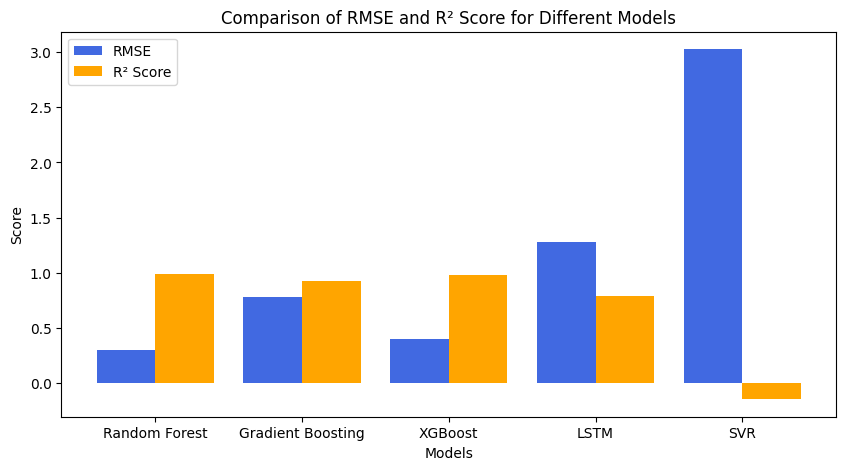

In [ ]:
plt.figure(figsize=(10, 5))

bar_width = 0.4
models = results['Model']
x = np.arange(len(models))

plt.bar(x - bar_width/2, results['RMSE'], width=bar_width, label='RMSE', color='royalblue')
plt.bar(x + bar_width/2, results['R² Score'], width=bar_width, label='R² Score', color='orange')

plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Comparison of RMSE and R² Score for Different Models")
plt.xticks(ticks=x, labels=models)
plt.legend()
plt.show()

In [ ]:
user_input_rain = np.array([[district, year, season]])
predicted_rainfall = rf_r.predict(user_input_rain)[0]
print(f"Predicted Rainfall: {predicted_rainfall:.2f} mm")

# 3) predict temperature using predicted rainfall
user_input_temp = np.array([[district, year, season, predicted_rainfall]])
predicted_temperature = rf_t.predict(user_input_temp)[0]
print(f"Predicted Temperature: {predicted_temperature:.2f} °C")

Predicted Rainfall: 182.89 mm
Predicted Temperature: 26.15 °C
